# Exercise 3: Twitter Sentiment Analysis
## Vasileios Papadopoulos

This assignment is part of Natural Language Process course of M.Sc in Artificial Intelligence from the University of Piraeus

## Setup

Install TexBlob using pip and import all necessary modules

In [1]:
# !pip3 install textblob

from textblob import TextBlob
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, plot_roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.utils import compute_class_weight
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn import preprocessing

import matplotlib.pyplot as plt  
import seaborn as sns

## Read the test dataset from the file provided in the link above

In [2]:
import pandas as pd
import numpy as np

file = 'twitter-2016test-A-clean.tsv'
bloblist = list()

df = pd.read_csv(file ,sep='\t')
print(df.shape)
df.head()

(15651, 3)


,tweet_id,sentiment,text
0,619950566786113536,neutral,"Picturehouse's, Pink Floyd's, 'Roger Waters: T..."
1,619969366986235905,neutral,Order Go Set a Watchman in store or through ou...
2,619974445185302528,neutral,If you could ask an onstage interview question...
3,619987808317407232,positive,A portion of book sales from our Harper Lee/Go...
4,619994586182619136,positive,"Excited to read ""Go Set a Watchman"" on Tuesday..."


### Class Distribution

We see that the dataset is skewed as the distribution favors the class *neutral*. Dataset is imbalanced.

neutral     7839
positive    5502
negative    2310
Name: sentiment, dtype: int64


<AxesSubplot:>

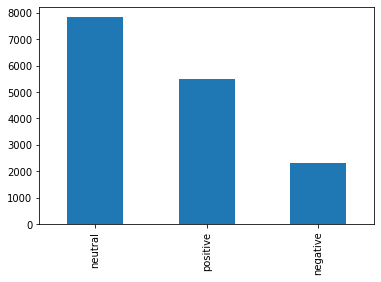

In [3]:
labels_count = df['sentiment'].value_counts()
print(labels_count)

labels_count.plot.bar()

In [4]:
'''Compute class weights'''

class_weights = compute_class_weight('balanced',
                                                 np.unique(df['sentiment']),
                                                 df['sentiment'])
# class_weights = dict(enumerate(class_weights))
print(class_weights)

[2.25844156 0.66551856 0.94820065]


/usr/local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=['negative' 'neutral' 'positive'], y=0         neutral
1         neutral
2         neutral
3        positive
4        positive
           ...   
15646     neutral
15647    positive
15648     neutral
15649    negative
15650     neutral
Name: sentiment, Length: 15651, dtype: object as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


## For each tweet in the dataset you need to create a TextBlob object

In [5]:
'''For every tweet-text create a TextBlob and append into list'''
blobs = []
for index in df.index:
    blobs.append(TextBlob(df['text'][index]))


##  Read the documentation and find which attribute contains the polarity.

The sentiment property returns a namedtuple of the form Sentiment(polarity, subjectivity). 
Polarity is float which lies in the range of [-1,1] where 1 means positive statement and -1 means a negative statement.
Subjective sentences generally refer to personal opinion, emotion or judgment whereas objective refers to factual information. Subjectivity is also a float which lies in the range of [0,1]

In [6]:
print(f'First tweet Polarity and Subjectivity {blobs[0].sentiment}')

First tweet Polarity and Subjectivity Sentiment(polarity=-0.1, subjectivity=0.3)


## Return the polarity of each tweet in terms of positive, negative or neutral (make sure you document your assumptions)

We extract informative features

In [7]:
'''Calculate and store polarity for every tweet'''
polarities = []
subjectivities = []
for b in blobs:
    polarities.append(b.sentiment.polarity)
    subjectivities.append(b.sentiment.subjectivity)

#append polarity and subjectivity into dataframe
df['polarity'] = np.array(polarities)
df['subjectivity'] = np.array(subjectivities)
df.head()

,tweet_id,sentiment,text,polarity,subjectivity
0,619950566786113536,neutral,"Picturehouse's, Pink Floyd's, 'Roger Waters: T...",-0.100000,0.300000
1,619969366986235905,neutral,Order Go Set a Watchman in store or through ou...,-0.208333,0.166667
2,619974445185302528,neutral,If you could ask an onstage interview question...,0.000000,0.000000
3,619987808317407232,positive,A portion of book sales from our Harper Lee/Go...,0.800000,0.750000
4,619994586182619136,positive,"Excited to read ""Go Set a Watchman"" on Tuesday...",0.255682,0.625000


## Calculate the accuracy, precision, recall and f-score of the classification

We will use polarity feature as independent variable to classify tweet's sentiment. The are 3 classes [Negative, Neutral, Positive]

In [8]:
'''Prepare datase get X and Y '''
# scaler = MinMaxScaler()
# df['polarity'] = scaler.fit_transform(df[['polarity']])

X = np.array(df['polarity'])
y = np.array(df['sentiment'])
X = X.reshape(X.shape[0], 1)
y = y.reshape(y.shape[0], 1)

# dividing X, y into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)
print(f'X_train shape is {X_train.shape}')
print(f'X_test shape is {X_test.shape}')

X_train shape is (12520, 1)
X_test shape is (3131, 1)


<AxesSubplot:ylabel='Frequency'>

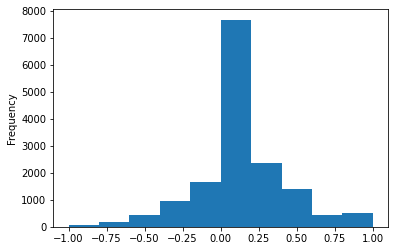

In [9]:
df['polarity'].plot.hist()

## Pipelines

In [10]:
pipelines = [
    Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel='rbf', probability=True))]),
    Pipeline([('scaler', StandardScaler()), ('rf', RandomForestClassifier())]),
    Pipeline([('scaler', StandardScaler()), ('nb', GaussianNB())])
]

pipe_dictionary = {0:'SVC', 
                   1:'Random Forest', 
                   2:'Naive Bayes'}

In [11]:
#fit pipelines
for index, model in enumerate(pipelines):
    model.fit(X_train, y_train.ravel())
    accuracy = model.score(X_train, y_train)
    print(f'{pipe_dictionary[index]} - Train set accuracy is {accuracy}')


SVC - Train set accuracy is 0.5753993610223642
Random Forest - Train set accuracy is 0.6309105431309904
Naive Bayes - Train set accuracy is 0.5676517571884984


In [12]:
#print classification report
labels = ['negative', 'neutral', 'positive']
for index, model in enumerate(pipelines):
    accu = model.score(X_test, y_test.ravel())
    print(f'{pipe_dictionary[index]} Test set accuracy : {accu}')
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, target_names=labels)
    print(f'{report}')

SVC Test set accuracy : 0.5685084637496007
              precision    recall  f1-score   support

    negative       0.54      0.06      0.10       459
     neutral       0.56      0.83      0.67      1570
    positive       0.59      0.41      0.49      1102

    accuracy                           0.57      3131
   macro avg       0.56      0.43      0.42      3131
weighted avg       0.57      0.57      0.52      3131

Random Forest Test set accuracy : 0.5726604918556372
              precision    recall  f1-score   support

    negative       0.44      0.11      0.17       459
     neutral       0.57      0.80      0.67      1570
    positive       0.59      0.44      0.51      1102

    accuracy                           0.57      3131
   macro avg       0.53      0.45      0.45      3131
weighted avg       0.56      0.57      0.54      3131

Naive Bayes Test set accuracy : 0.5662727563078889
              precision    recall  f1-score   support

    negative       0.52      0.11   

### Confusion Matrix

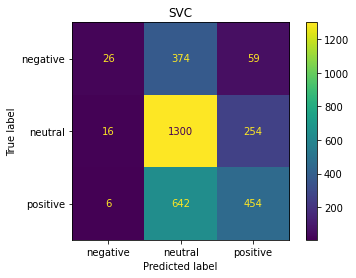

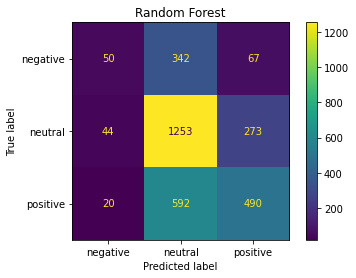

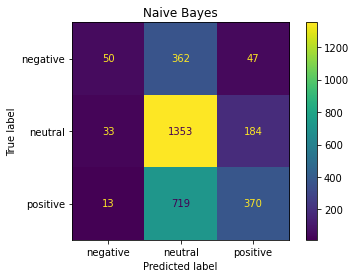

In [15]:
for index, model in enumerate(pipelines):
    disp = plot_confusion_matrix(model, X_test, y_test)  
    disp.ax_.set_title(pipe_dictionary[index])
plt.show()  

## Area Under ROC (AUROC)

Get the prediction probabilites of the model on test-set.

In [16]:
#Binarize y_test
le = preprocessing.LabelBinarizer()
le.fit(np.array(y_test))

y_test_binarized = le.transform(y_test)
print(y_test_binarized)   

[[0 1 0]
 [0 0 1]
 [0 1 0]
 ...
 [0 0 1]
 [0 1 0]
 [0 1 0]]


### ROC Definition

For multi-class problems, we can plot N number of ROC curvers where N is the number of classes. We use the ONE vs ALL technique; 

* Negative class against (Positive, Neutral)
* Positive class against (Negative, Neutral)
* Neutral class against  (Positive, Negative)

Ideally, the best classifier produces ROC curves that lie as much as possible at the left-top corner of the plot.
AUC value equal to 0.5 denotes the worst case meaning the classifier has no discriminative ability to distinquish among classes. 
AUC equal to 0 the classifier predicts true positive classes as negative and vice versa


In [17]:
for index, model in enumerate(pipelines):
    probs = model.predict_proba(X_test)
    roc = roc_auc_score(y_test_binarized, probs, multi_class='ovr')
    print(f'{pipe_dictionary[index]} - AUROC {roc}')

SVC - AUROC 0.6417874676850894
Random Forest - AUROC 0.6573450913841806
Naive Bayes - AUROC 0.6634667603447225


In [27]:
# helper function
def plot_multiclass_roc(y_test, y_probs, model, labels, figsize=(17, 6)):
    
    n_classes = len(labels)
    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])


    # roc for each class
    fig, ax = plt.subplots(figsize = figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'{model} Receiver operating characteristic')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %s' % (roc_auc[i], labels[i]))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()


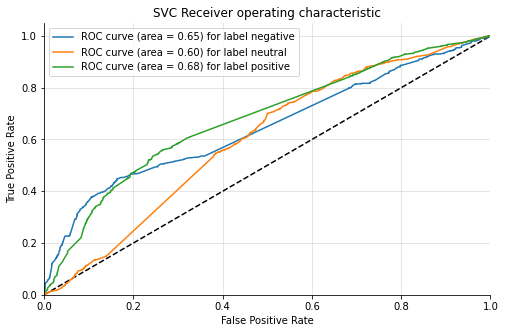

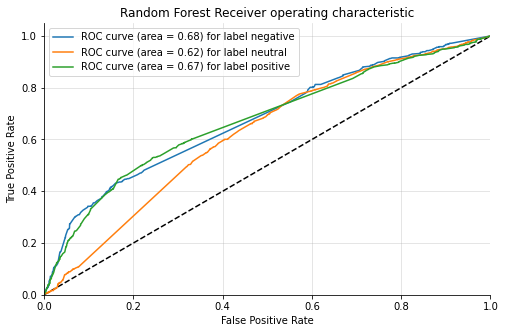

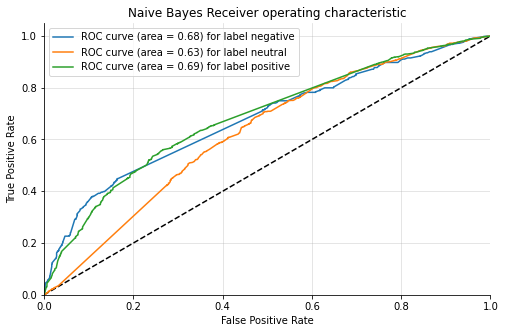

In [28]:
for index, model in enumerate(pipelines):
    probs = model.predict_proba(X_test)
    disp = plot_multiclass_roc(y_test_binarized, probs, 
                        pipe_dictionary[index], 
                        labels, 
                        figsize = (8,5))